In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as pf
import xaosim as xs
from xaosim.pupil import PHARO
from scipy.ndimage import rotate
import xara

from tqdm import tqdm


import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


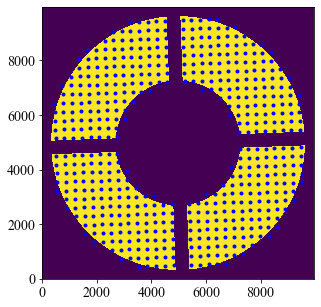

In [2]:

binary_model = False # use a finer transmission model for the aperture
PSZ     = 4978*2   # size of the array for the model
pdiam   = 4.978    # telescope diameter in meters
mstep   = 0.160    # step size in meters

pmask   = PHARO(PSZ, PSZ/2, mask="med")
pmask2  = PHARO(PSZ, PSZ/2, mask="med", ang=-2) # rotated!
ppscale = pdiam / PSZ

if binary_model:
        mtype="bina"
        p3k_model = xara.core.create_discrete_model(
                pmask, ppscale, mstep, binary=True, tmin=0.4)
else:
        mtype="grey"
        p3k_model = xara.core.create_discrete_model(
                pmask, ppscale, mstep, binary=False, tmin=0.05)
        p3k_model[:,2] = np.round(p3k_model[:,2],2)

# rotate the model by two degrees
# --------------------------------

th0 = -2.0 * np.pi / 180.0 # rotation angle
rmat = np.array([[np.cos(th0), -np.sin(th0)],
                                 [np.sin(th0), np.cos(th0)]])

p3k_model[:,:2] = p3k_model[:,:2].dot(rmat)

# -------------------------
#      simple plot
# -------------------------
f0 = plt.figure(0)
f0.clf()
ax = f0.add_subplot(111)
ax.imshow(pmask2)
ax.plot(PSZ/2+p3k_model[:,0]/ppscale,
                 PSZ/2+p3k_model[:,1]/ppscale, 'b.')
f0.set_size_inches(5,5, forward=True)

#f0.savefig("./imgs/PHARO/rotated_pupil.png")
# -------------------------


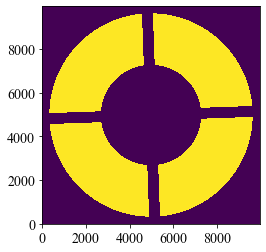

In [3]:
plt.imshow(pmask2)

In [4]:
# # compute the kernel-phase data structure
# kpo_0 = xara.KPO(array=p3k_model, bmax=4.646)

# # show side by side, the pupil model and its associated uv-coverage
# kpo_0.kpi.plot_pupil_and_uv(xymax=2.5, cmap=cm.plasma_r, ssize=9, figsize=(10,5), marker='o')

# # and save to a multi-extension kernel-phase fits file for later use
# fname = "p3k_med_%s_model.fits" % (mtype,)
# print("saving %s" % (fname,))
# kpo_0.save_as_fits(fname)


In [5]:
fname = 'test_pharo_s125_th86_c25_cube.fits'

In [6]:
kp_fname = 'test_pharo_s125_th86_c25_cube.fits'


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import xara

tgt_cube = pf.getdata(fname) # alpha Ophiuchi

pscale = 25.0              # plate scale of the image in mas/pixels
wl     = 2.145e-6          # central wavelength in meters (Hayward paper)
ISZ    = tgt_cube.shape[1] # image size
kpo1   = xara.KPO(fname="p3k_med_grey_model.fits")

kpo1.extract_KPD_single_cube(
        tgt_cube, pscale, wl,target="alpha Ophiuchi", recenter=True)


Attempting to load file p3k_med_grey_model.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available

Cube slice   1 / 1000First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 1000 / 1000

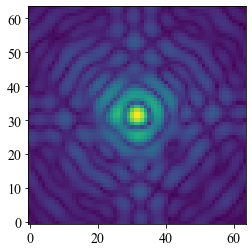

In [8]:
plt.imshow(tgt_cube[0,:,:]**0.25)

In [9]:
data1 = np.array(kpo1.KPDT)

mydata = np.median(data1[0,:,:],axis=0)
myerr = np.sqrt( 0.00132**2)
myerr = np.std(data1[0,:,:],axis=0)/np.sqrt(tgt_cube.shape[0])+0.0000001

In [10]:
mydata.shape

(1048,)

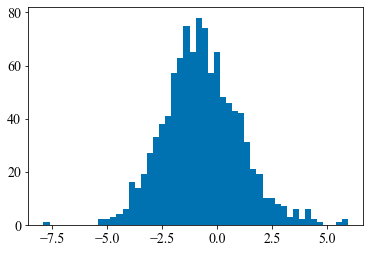

In [11]:
plt.hist(mydata,bins=50);

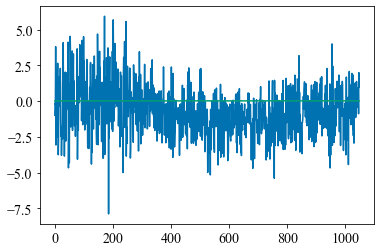

In [12]:
plt.plot(mydata)
plt.plot(myerr)


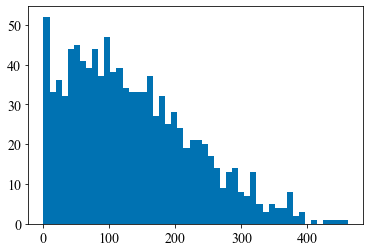

In [13]:
plt.hist(np.abs(mydata)/myerr,bins=50);


In [14]:
print(np.median(np.abs(mydata)/myerr))

119.19585397084319


In [15]:
print("\ncomputing colinearity map...")
gsize = 100 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap = kpo1.kpd_binary_match_map(100, 10, mydata, norm=True)

x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))



computing colinearity map...
max colinearity found for sep = 100.50 mas and ang = 84.29 deg


In [16]:
# kpo1.kpi.plot_pupil_and_uv()

In [17]:
truth = [125,86,25]
model = kpo1.kpd_binary_model(truth, 0, 'KERNEL')
model.shape

(1000, 1048)

In [18]:
kpo1.kpi.UVC.dtype

dtype('float64')


binary model fitting...
sep = 125.058194, ang=85.959036, con=24.975928 => chi2 = 1.192
correlation matrix of parameters
[[ 0.13 -0.   -0.06]
 [-0.    0.01 -0.  ]
 [-0.06 -0.    0.05]]


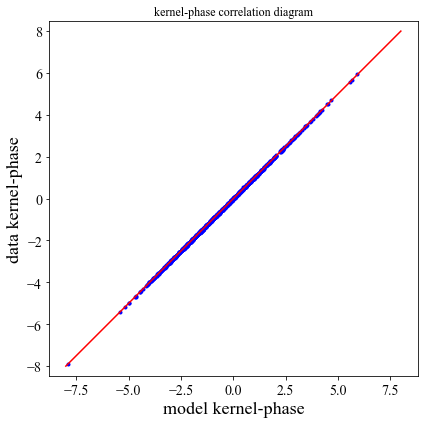

In [19]:
print("\nbinary model fitting...")
p0 = [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point

mfit = kpo1.binary_model_fit(p0)
p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)

cvis_b = xara.core.cvis_binary(
        kpo1.kpi.UVC[:,0], kpo1.kpi.UVC[:,1], wl, p1) # binary
ker_theo = kpo1.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=myerr, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = np.round(np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
# ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/myerr)**2) / kpo1.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / kpo1.kpi.nbkp

print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
print("correlation matrix of parameters")
print(np.round(mfit[1], 2))


In [20]:
mfit

(array([125.05819445,  85.95903623,  24.97592806]),
 array([[ 0.13275799, -0.00073771, -0.06345214],
        [-0.00073771,  0.01085324, -0.000391  ],
        [-0.06345214, -0.000391  ,  0.05267246]]),
 {'fvec': array([-0.06313467,  0.1053169 , -0.04502932, ...,  0.05396513,
         -0.02330034, -0.00590343]),
  'nfev': 22,
  'fjac': array([[-9.61165643e+00,  3.72830913e-02, -6.15380727e-02, ...,
           2.71789370e-02,  8.48244864e-04,  6.10351191e-02],
         [-3.19850268e-01,  6.68970588e+00,  6.95496491e-03, ...,
           1.64334077e-02, -2.51513234e-02, -2.60689743e-02],
         [-2.06283983e-01,  3.19736829e+00,  2.74454064e+00, ...,
          -7.70576055e-03,  2.25313919e-02,  6.96126759e-02]]),
  'ipvt': array([2, 3, 1], dtype=int32),
  'qtf': array([ 1.77896358e-05, -1.52440587e-07,  6.00126192e-06])},
 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 1)

In [21]:
p1

array([125.05819445,  85.95903623,  24.97592806])

### Let's try emcee

In [22]:
import emcee

In [23]:
phase_data = np.angle(kpo1.CVIS)[0,0,:]
phase_err = 0.01*np.ones_like(phase_data)

In [24]:
paramlimits=[40,250,0,360,1.1,50.]

def binary_model(params,kpo):
    u = kpo.kpi.UVC[:,0]
    v = kpo.kpi.UVC[:,1]
    wl = kpo.CWAVEL
    detpa = 0
    return(xara.core.cvis_binary(u,v,wl, params, detpa))

def kp_loglikelihood(params,kpo):
    temp = binary_model(params,kpo)
    model = kpo.kpi.KPM.dot(np.angle(temp))
    error = mydata-model
    error /= (myerr)
    chi2 = -np.sum((error)**2)
    return chi2 

def phase_loglikelihood(params,kpo):
    temp = binary_model(params,kpo)
    model = (np.angle(temp))
    error = phase_data-model
    error /= (phase_err)
    chi2 = -np.sum((error)**2)
    return chi2 

def lnprior(params):
    if paramlimits[0] < params[0] < paramlimits[1] and paramlimits[2] < params[1] < paramlimits[3] and paramlimits[4] < params[2] < paramlimits[5]:
        return -np.log(params[0]) -np.log(params[2])
    return -np.inf

def lnprob(params,kpo):
    return lnprior(params) + kp_loglikelihood(params,kpo)

ndim=3
nwalkers=100
plot=False
burnin=100
nsteps=1000

import time


In [25]:
ivar = np.array([125,86,25])  # initial parameters for model-fit

ball = np.array([ivar + 0.1*ivar*np.random.rand(ndim) for i in range(nwalkers)]) # initialise walkers in a ball

print('Running emcee now!')

t0 = time.time()

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[kpo1])

# burn in
pos,prob,state = sampler.run_mcmc(ball, burnin)
sampler.reset()

t1 = time.time()

print('Burnt in! Took %.3f seconds' %(t1-t0))


Running emcee now!
Burnt in! Took 52.091 seconds


In [26]:
# restart
sampler.run_mcmc(pos,nsteps)

tf = time.time()

print('Time elapsed = %.3f s' %(tf-t0))

seps = sampler.flatchain[:,0]
ths = sampler.flatchain[:,1]

meansep = np.mean(seps)
dsep = np.std(seps)

meanth = np.mean(ths)
dth = np.std(ths)

cs = sampler.flatchain[:,2]
bestcon = np.mean(cs)
conerr = np.std(cs)

print('Separation %.3f pm %.3f mas' % (meansep,dsep))
print('Position angle %.3f pm %.3f deg' % (meanth,dth))
print('Contrast at',wl,'um %.3f pm %.3f' % (bestcon,conerr))


Time elapsed = 469.038 s
Separation 125.065 pm 0.008 mas
Position angle 85.981 pm 0.002 deg
Contrast at 2.145e-06 um 24.957 pm 0.005


In [27]:
import corner

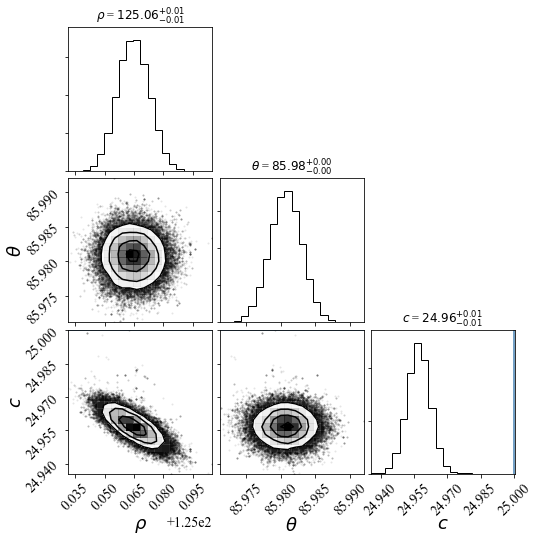

In [28]:
# Plot it.
figure = corner.corner(sampler.flatchain, labels=[r"$\rho$", r"$\theta$", r"$c$",],
                       truths=[125,86,25],
                       show_titles=True, title_kwargs={"fontsize": 12})

plt.savefig('frantz_fit.png',bbox_inches='tight')

In [29]:
autodiff = np.loadtxt('autodiff_sim_posterior.txt')

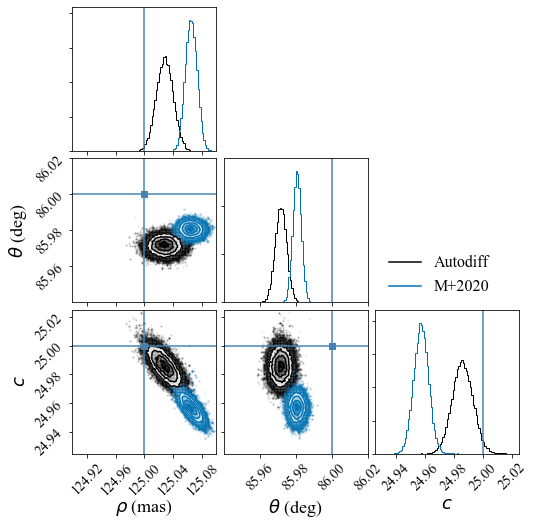

In [30]:
# Plot it.
import matplotlib.lines as mlines

# Plot it.
plotrange = ((123,127),(85.5,86.5),(24,26))
plotrange = ((124.9,125.1), (85.94,86.02),(24.925,25.025))
hist_kwargs = {}

figure = corner.corner(autodiff, range=plotrange, labels=[r"$\rho$ (mas)", r"$\theta$ (deg)", r"$c$",],
                       show_titles=False, title_kwargs={"fontsize": 12},color='k',bins=100,
                       scale_hist=True,truths=[125,86,25]
                       )

corner.corner(sampler.flatchain, fig=figure,color=colours[0],range=plotrange,bins=100)


lines = [mlines.Line2D([], [], color='k', label='Autodiff'),mlines.Line2D([], [], color=colours[0], label='M+2020')]
plt.legend(handles=lines, bbox_to_anchor=(0., 1.0, 1., .0),fontsize=16,frameon=False);
plt.savefig('comparison_posterior.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/comparison_posterior_sim.pdf',bbox_inches='tight')

### Compare against an ensemble

In [31]:
# %%time 
# seps = [75,100,125,150]
# cons = [10,25,50]
# thetas = [0,90,180,270]

# results = []
# seps_in = []
# cons_in = []

# theta = 90
# for sep in tqdm(seps):
#     for theta in thetas:
#         for con in cons:
#             fname = 'test_pharo_s%d_th%d_c%d.fits' % (sep,theta,con)
#             img = pf.getdata(fname)
#             kpo1 = kpo2.copy()
#             kpo1.extract_KPD_single_frame(
#             img, pscale, wl,target="alpha Ophiuchi", recenter=True,method='LDFT1')
#             truth = [sep,theta,con]

#             mfit = kpo1.binary_model_fit(truth)
#             p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
#             results.append(p1)
#             seps_in.append(sep)
#             cons_in.append(con)

# seps_in = np.array(seps_in)
# cons_in = np.array(cons_in)
# seps_out = np.array([result[0] for result in results])
# cons_out = np.array([result[1] for result in results])

In [32]:
# seps_out = [result[0] for result in results]
# cons_out = [result[1] for result in results]

In [33]:
# plt.plot(seps_in,seps_in,'-r')
# plt.scatter(seps_in,seps_out,c=cons_in)


In [34]:
# plt.plot(seps_in,np.zeros_like(seps_in),'-r')
# plt.scatter(seps_in,seps_out-seps_in,c=cons_in)
# plt.colorbar()
# # plt.ylim(-1,6)

In [35]:
%%time 

kpo0   = xara.KPO(fname="p3k_med_grey_model.fits")

truth = [125.,86.,25.]
nsim = tgt_cube.shape[0]

results = []

for j in tqdm(range(nsim)):
    img = tgt_cube[j,:,:]
    kpo1 = kpo0.copy()
    kpo1.extract_KPD_single_frame(
    img, pscale, wl,target="alpha Ophiuchi", recenter=True,method='LDFT1')

    mfit = kpo1.binary_model_fit(truth)
    p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
    results.append(p1)

seps_out = np.array([result[0] for result in results])
thetas_out = np.array([result[1] for result in results])
cons_out = np.array([result[2] for result in results])

  0%|          | 0/1000 [00:00<?, ?it/s]

Attempting to load file p3k_med_grey_model.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  0%|          | 1/1000 [00:00<06:25,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  0%|          | 2/1000 [00:00<06:19,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  0%|          | 3/1000 [00:01<06:08,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  0%|          | 4/1000 [00:01<06:09,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  0%|          | 5/1000 [00:01<06:04,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|          | 6/1000 [00:02<06:01,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|          | 7/1000 [00:02<06:04,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|          | 8/1000 [00:02<06:01,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|          | 9/1000 [00:03<06:02,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|          | 10/1000 [00:03<06:03,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|          | 11/1000 [00:04<05:58,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|          | 12/1000 [00:04<05:55,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|▏         | 13/1000 [00:04<05:56,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  1%|▏         | 14/1000 [00:05<05:54,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 15/1000 [00:05<05:53,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 16/1000 [00:05<05:57,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 17/1000 [00:06<05:59,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 18/1000 [00:06<06:08,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 19/1000 [00:06<06:11,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 20/1000 [00:07<06:09,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 21/1000 [00:07<06:05,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 22/1000 [00:08<06:06,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 23/1000 [00:08<06:04,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▏         | 24/1000 [00:08<06:05,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  2%|▎         | 25/1000 [00:09<06:12,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 26/1000 [00:09<06:10,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 27/1000 [00:09<06:09,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 28/1000 [00:10<06:00,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 29/1000 [00:10<06:01,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 30/1000 [00:11<06:41,  2.42it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 31/1000 [00:11<07:07,  2.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 32/1000 [00:12<06:47,  2.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 33/1000 [00:12<06:43,  2.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  3%|▎         | 34/1000 [00:12<06:38,  2.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▎         | 35/1000 [00:13<06:24,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▎         | 36/1000 [00:13<06:09,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▎         | 37/1000 [00:13<05:59,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▍         | 38/1000 [00:14<05:58,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▍         | 39/1000 [00:14<06:02,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▍         | 40/1000 [00:15<05:59,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▍         | 41/1000 [00:15<05:53,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▍         | 42/1000 [00:15<06:04,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▍         | 43/1000 [00:16<06:05,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▍         | 44/1000 [00:16<06:06,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  4%|▍         | 45/1000 [00:17<07:16,  2.19it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▍         | 46/1000 [00:18<09:04,  1.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▍         | 47/1000 [00:18<08:55,  1.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▍         | 48/1000 [00:19<08:20,  1.90it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▍         | 49/1000 [00:19<08:12,  1.93it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▌         | 50/1000 [00:19<07:31,  2.10it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▌         | 51/1000 [00:20<07:01,  2.25it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▌         | 52/1000 [00:20<06:51,  2.30it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▌         | 53/1000 [00:21<06:32,  2.42it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  5%|▌         | 54/1000 [00:21<06:13,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▌         | 55/1000 [00:21<05:57,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▌         | 56/1000 [00:22<05:48,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▌         | 57/1000 [00:22<05:40,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▌         | 58/1000 [00:22<05:38,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▌         | 59/1000 [00:23<05:45,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▌         | 60/1000 [00:23<05:46,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▌         | 61/1000 [00:23<05:43,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▌         | 62/1000 [00:24<05:42,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▋         | 63/1000 [00:24<05:45,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▋         | 64/1000 [00:25<05:45,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  6%|▋         | 65/1000 [00:25<05:41,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 66/1000 [00:25<05:38,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 67/1000 [00:26<05:49,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 68/1000 [00:26<05:53,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 69/1000 [00:26<05:50,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 70/1000 [00:27<05:59,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 71/1000 [00:27<06:02,  2.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 72/1000 [00:28<05:57,  2.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 73/1000 [00:28<05:57,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  7%|▋         | 74/1000 [00:29<06:36,  2.34it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 75/1000 [00:29<06:53,  2.24it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 76/1000 [00:30<06:59,  2.20it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 77/1000 [00:30<06:39,  2.31it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 78/1000 [00:30<06:23,  2.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 79/1000 [00:31<06:02,  2.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 80/1000 [00:31<05:50,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 81/1000 [00:31<05:45,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 82/1000 [00:32<05:56,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 83/1000 [00:32<05:52,  2.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 84/1000 [00:32<05:48,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  8%|▊         | 85/1000 [00:33<05:45,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▊         | 86/1000 [00:33<05:42,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▊         | 87/1000 [00:34<05:41,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▉         | 88/1000 [00:34<05:54,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▉         | 89/1000 [00:34<05:41,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▉         | 90/1000 [00:35<05:32,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▉         | 91/1000 [00:35<05:25,  2.80it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▉         | 92/1000 [00:35<05:26,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▉         | 93/1000 [00:36<05:28,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


  9%|▉         | 94/1000 [00:36<05:27,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|▉         | 95/1000 [00:37<05:28,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|▉         | 96/1000 [00:37<05:35,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|▉         | 97/1000 [00:37<05:35,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|▉         | 98/1000 [00:38<05:34,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|▉         | 99/1000 [00:38<05:40,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|█         | 100/1000 [00:38<05:33,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|█         | 101/1000 [00:39<05:27,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|█         | 102/1000 [00:39<05:27,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|█         | 103/1000 [00:39<05:26,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|█         | 104/1000 [00:40<05:30,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 10%|█         | 105/1000 [00:40<05:33,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█         | 106/1000 [00:41<05:34,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█         | 107/1000 [00:41<05:31,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█         | 108/1000 [00:41<05:29,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█         | 109/1000 [00:42<05:29,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█         | 110/1000 [00:42<05:27,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█         | 111/1000 [00:42<05:34,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█         | 112/1000 [00:43<05:30,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█▏        | 113/1000 [00:43<05:25,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 11%|█▏        | 114/1000 [00:44<05:28,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 115/1000 [00:44<05:23,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 116/1000 [00:44<05:21,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 117/1000 [00:45<05:19,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 118/1000 [00:45<05:15,  2.80it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 119/1000 [00:45<05:16,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 120/1000 [00:46<05:22,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 121/1000 [00:46<05:19,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 122/1000 [00:47<05:43,  2.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 123/1000 [00:47<05:57,  2.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▏        | 124/1000 [00:47<05:51,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 12%|█▎        | 125/1000 [00:48<06:19,  2.30it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 126/1000 [00:48<06:26,  2.26it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 127/1000 [00:49<06:05,  2.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 128/1000 [00:49<06:01,  2.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 129/1000 [00:49<05:45,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 130/1000 [00:50<05:48,  2.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 131/1000 [00:50<05:41,  2.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 132/1000 [00:51<05:48,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 133/1000 [00:51<06:00,  2.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 13%|█▎        | 134/1000 [00:51<05:49,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▎        | 135/1000 [00:52<05:38,  2.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▎        | 136/1000 [00:52<05:30,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▎        | 137/1000 [00:53<05:23,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▍        | 138/1000 [00:53<05:21,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▍        | 139/1000 [00:53<05:17,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▍        | 140/1000 [00:54<05:48,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▍        | 141/1000 [00:54<05:41,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▍        | 142/1000 [00:55<05:32,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▍        | 143/1000 [00:55<05:27,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▍        | 144/1000 [00:55<05:32,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 14%|█▍        | 145/1000 [00:56<05:31,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▍        | 146/1000 [00:56<05:30,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▍        | 147/1000 [00:56<05:34,  2.55it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▍        | 148/1000 [00:57<05:33,  2.55it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▍        | 149/1000 [00:57<05:30,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▌        | 150/1000 [00:58<05:24,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▌        | 151/1000 [00:58<05:35,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▌        | 152/1000 [00:59<05:55,  2.38it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▌        | 153/1000 [00:59<05:58,  2.36it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 15%|█▌        | 154/1000 [00:59<06:03,  2.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▌        | 155/1000 [01:00<06:03,  2.32it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▌        | 156/1000 [01:00<06:10,  2.28it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▌        | 157/1000 [01:01<06:10,  2.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▌        | 158/1000 [01:01<06:02,  2.32it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▌        | 159/1000 [01:02<05:45,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▌        | 160/1000 [01:02<05:33,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▌        | 161/1000 [01:02<05:22,  2.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▌        | 162/1000 [01:03<05:13,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▋        | 163/1000 [01:03<05:19,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▋        | 164/1000 [01:03<05:17,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 16%|█▋        | 165/1000 [01:04<05:13,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 166/1000 [01:04<05:14,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 167/1000 [01:04<05:11,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 168/1000 [01:05<05:10,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 169/1000 [01:05<05:08,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 170/1000 [01:06<05:11,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 171/1000 [01:06<05:04,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 172/1000 [01:06<05:32,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 173/1000 [01:07<07:02,  1.96it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 17%|█▋        | 174/1000 [01:08<07:26,  1.85it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 175/1000 [01:08<07:22,  1.86it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 176/1000 [01:09<06:51,  2.00it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 177/1000 [01:09<06:23,  2.15it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 178/1000 [01:09<05:56,  2.30it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 179/1000 [01:10<05:33,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 180/1000 [01:10<05:52,  2.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 181/1000 [01:11<05:55,  2.30it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 182/1000 [01:11<05:44,  2.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 183/1000 [01:12<05:32,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 184/1000 [01:12<05:22,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 18%|█▊        | 185/1000 [01:12<05:16,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▊        | 186/1000 [01:13<05:23,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▊        | 187/1000 [01:13<05:19,  2.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▉        | 188/1000 [01:13<05:25,  2.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▉        | 189/1000 [01:14<05:24,  2.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▉        | 190/1000 [01:14<05:27,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▉        | 191/1000 [01:15<05:24,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▉        | 192/1000 [01:15<05:13,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▉        | 193/1000 [01:15<05:13,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 19%|█▉        | 194/1000 [01:16<05:35,  2.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|█▉        | 195/1000 [01:16<05:40,  2.36it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|█▉        | 196/1000 [01:17<05:46,  2.32it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|█▉        | 197/1000 [01:17<05:32,  2.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|█▉        | 198/1000 [01:18<05:19,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|█▉        | 199/1000 [01:18<05:11,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|██        | 200/1000 [01:18<05:14,  2.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|██        | 201/1000 [01:19<05:09,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|██        | 202/1000 [01:19<04:59,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|██        | 203/1000 [01:19<04:51,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|██        | 204/1000 [01:20<05:30,  2.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 20%|██        | 205/1000 [01:20<05:22,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 21%|██        | 206/1000 [01:21<05:31,  2.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 21%|██        | 207/1000 [01:21<05:25,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 21%|██        | 208/1000 [01:21<05:10,  2.55it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 21%|██        | 209/1000 [01:22<05:23,  2.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!


 21%|██        | 210/1000 [01:23<06:12,  2.12it/s]

First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 21%|██        | 211/1000 [01:23<05:55,  2.22it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 21%|██        | 212/1000 [01:23<05:52,  2.24it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 21%|██▏       | 213/1000 [01:24<05:47,  2.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 21%|██▏       | 214/1000 [01:24<05:56,  2.20it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 215/1000 [01:25<05:44,  2.28it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 216/1000 [01:25<06:02,  2.16it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 217/1000 [01:26<06:08,  2.12it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 218/1000 [01:26<05:43,  2.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 219/1000 [01:27<06:01,  2.16it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 220/1000 [01:27<06:16,  2.07it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 221/1000 [01:28<06:40,  1.95it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 222/1000 [01:28<06:25,  2.02it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 223/1000 [01:29<06:03,  2.14it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▏       | 224/1000 [01:29<05:42,  2.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 22%|██▎       | 225/1000 [01:29<05:18,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 226/1000 [01:30<05:06,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 227/1000 [01:30<05:13,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 228/1000 [01:30<05:17,  2.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 229/1000 [01:31<05:37,  2.29it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 230/1000 [01:31<05:31,  2.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 231/1000 [01:32<05:22,  2.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 232/1000 [01:32<05:04,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 233/1000 [01:32<04:50,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 23%|██▎       | 234/1000 [01:33<05:04,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▎       | 235/1000 [01:33<05:37,  2.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▎       | 236/1000 [01:34<05:38,  2.25it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▎       | 237/1000 [01:34<05:20,  2.38it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▍       | 238/1000 [01:35<05:12,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▍       | 239/1000 [01:35<05:00,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▍       | 240/1000 [01:35<04:56,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▍       | 241/1000 [01:36<04:50,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▍       | 242/1000 [01:36<04:45,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▍       | 243/1000 [01:37<04:48,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▍       | 244/1000 [01:37<04:50,  2.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 24%|██▍       | 245/1000 [01:37<04:48,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▍       | 246/1000 [01:38<05:01,  2.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▍       | 247/1000 [01:38<04:56,  2.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▍       | 248/1000 [01:38<04:51,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▍       | 249/1000 [01:39<04:45,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▌       | 250/1000 [01:39<04:43,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▌       | 251/1000 [01:40<04:39,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▌       | 252/1000 [01:40<04:45,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▌       | 253/1000 [01:40<04:41,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 25%|██▌       | 254/1000 [01:41<04:36,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▌       | 255/1000 [01:41<04:33,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▌       | 256/1000 [01:41<04:39,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▌       | 257/1000 [01:42<04:32,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▌       | 258/1000 [01:42<04:32,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▌       | 259/1000 [01:43<04:30,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▌       | 260/1000 [01:43<04:29,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▌       | 261/1000 [01:43<04:30,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▌       | 262/1000 [01:44<04:27,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▋       | 263/1000 [01:44<04:23,  2.80it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▋       | 264/1000 [01:44<04:27,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 26%|██▋       | 265/1000 [01:45<04:29,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 266/1000 [01:45<04:27,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 267/1000 [01:45<04:27,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 268/1000 [01:46<04:31,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 269/1000 [01:46<04:27,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 270/1000 [01:47<04:29,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 271/1000 [01:47<04:25,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 272/1000 [01:47<04:27,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 273/1000 [01:48<04:35,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 27%|██▋       | 274/1000 [01:48<04:37,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 275/1000 [01:48<04:34,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!


 28%|██▊       | 276/1000 [01:49<05:05,  2.37it/s]

First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 277/1000 [01:49<04:54,  2.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 278/1000 [01:50<04:40,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 279/1000 [01:50<04:39,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 280/1000 [01:50<04:42,  2.55it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 281/1000 [01:51<04:33,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 282/1000 [01:51<04:36,  2.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 283/1000 [01:52<04:31,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 284/1000 [01:52<04:34,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 28%|██▊       | 285/1000 [01:52<04:25,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▊       | 286/1000 [01:53<04:32,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▊       | 287/1000 [01:53<04:35,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▉       | 288/1000 [01:54<05:00,  2.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▉       | 289/1000 [01:54<04:57,  2.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▉       | 290/1000 [01:54<05:00,  2.36it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▉       | 291/1000 [01:55<04:58,  2.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▉       | 292/1000 [01:55<04:50,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▉       | 293/1000 [01:56<04:33,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 29%|██▉       | 294/1000 [01:56<04:23,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|██▉       | 295/1000 [01:56<04:20,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|██▉       | 296/1000 [01:57<04:16,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|██▉       | 297/1000 [01:57<04:17,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|██▉       | 298/1000 [01:57<04:24,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|██▉       | 299/1000 [01:58<04:18,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|███       | 300/1000 [01:58<04:17,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|███       | 301/1000 [01:58<04:11,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|███       | 302/1000 [01:59<04:18,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|███       | 303/1000 [01:59<04:28,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|███       | 304/1000 [02:00<04:43,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 30%|███       | 305/1000 [02:00<04:55,  2.36it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███       | 306/1000 [02:01<04:58,  2.32it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███       | 307/1000 [02:01<04:55,  2.34it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███       | 308/1000 [02:01<04:40,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███       | 309/1000 [02:02<04:34,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███       | 310/1000 [02:02<04:32,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███       | 311/1000 [02:03<04:37,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███       | 312/1000 [02:03<04:46,  2.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███▏      | 313/1000 [02:03<04:39,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 31%|███▏      | 314/1000 [02:04<05:03,  2.26it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 315/1000 [02:04<04:48,  2.38it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 316/1000 [02:05<04:36,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 317/1000 [02:05<05:05,  2.24it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 318/1000 [02:06<04:48,  2.36it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 319/1000 [02:06<04:38,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 320/1000 [02:07<05:08,  2.20it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 321/1000 [02:07<05:07,  2.21it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 322/1000 [02:07<04:47,  2.36it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 323/1000 [02:08<04:32,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▏      | 324/1000 [02:08<04:24,  2.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 32%|███▎      | 325/1000 [02:08<04:12,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 326/1000 [02:09<04:08,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 327/1000 [02:09<04:06,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 328/1000 [02:10<04:14,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 329/1000 [02:10<04:09,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 330/1000 [02:10<04:08,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 331/1000 [02:11<04:11,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 332/1000 [02:11<04:16,  2.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 333/1000 [02:11<04:13,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 33%|███▎      | 334/1000 [02:12<04:19,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▎      | 335/1000 [02:12<04:14,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▎      | 336/1000 [02:13<04:09,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▎      | 337/1000 [02:13<04:07,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▍      | 338/1000 [02:13<04:09,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▍      | 339/1000 [02:14<04:09,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▍      | 340/1000 [02:14<04:08,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▍      | 341/1000 [02:14<04:02,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▍      | 342/1000 [02:15<03:58,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▍      | 343/1000 [02:15<03:58,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▍      | 344/1000 [02:16<04:18,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 34%|███▍      | 345/1000 [02:16<04:25,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▍      | 346/1000 [02:16<04:19,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▍      | 347/1000 [02:17<04:28,  2.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▍      | 348/1000 [02:17<04:32,  2.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▍      | 349/1000 [02:18<04:20,  2.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▌      | 350/1000 [02:18<04:16,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▌      | 351/1000 [02:18<04:06,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▌      | 352/1000 [02:19<04:03,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▌      | 353/1000 [02:19<04:00,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 35%|███▌      | 354/1000 [02:19<03:56,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▌      | 355/1000 [02:20<03:52,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▌      | 356/1000 [02:20<03:56,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▌      | 357/1000 [02:21<03:52,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▌      | 358/1000 [02:21<03:50,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▌      | 359/1000 [02:21<03:54,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▌      | 360/1000 [02:22<03:52,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▌      | 361/1000 [02:22<03:53,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▌      | 362/1000 [02:22<03:50,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▋      | 363/1000 [02:23<03:52,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▋      | 364/1000 [02:23<03:50,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 36%|███▋      | 365/1000 [02:23<03:49,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 366/1000 [02:24<03:49,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 367/1000 [02:24<03:45,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 368/1000 [02:25<03:48,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 369/1000 [02:25<03:51,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 370/1000 [02:25<03:55,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 371/1000 [02:26<03:54,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 372/1000 [02:26<03:52,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 373/1000 [02:26<03:54,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 37%|███▋      | 374/1000 [02:27<03:51,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 375/1000 [02:27<03:54,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 376/1000 [02:28<03:49,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 377/1000 [02:28<03:50,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 378/1000 [02:28<03:56,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 379/1000 [02:29<04:03,  2.55it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 380/1000 [02:29<04:14,  2.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 381/1000 [02:30<04:09,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 382/1000 [02:30<04:05,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 383/1000 [02:30<04:01,  2.55it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 384/1000 [02:31<03:50,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 38%|███▊      | 385/1000 [02:31<03:51,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▊      | 386/1000 [02:31<03:43,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▊      | 387/1000 [02:32<03:44,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▉      | 388/1000 [02:32<03:44,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▉      | 389/1000 [02:32<03:41,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▉      | 390/1000 [02:33<03:39,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▉      | 391/1000 [02:33<03:35,  2.82it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▉      | 392/1000 [02:34<03:37,  2.80it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▉      | 393/1000 [02:34<03:34,  2.83it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 39%|███▉      | 394/1000 [02:34<03:34,  2.82it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|███▉      | 395/1000 [02:35<03:32,  2.85it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|███▉      | 396/1000 [02:35<03:43,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|███▉      | 397/1000 [02:35<03:36,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|███▉      | 398/1000 [02:36<03:32,  2.83it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|███▉      | 399/1000 [02:36<03:33,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|████      | 400/1000 [02:36<03:39,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|████      | 401/1000 [02:37<03:40,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|████      | 402/1000 [02:37<03:35,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|████      | 403/1000 [02:37<03:34,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|████      | 404/1000 [02:38<03:39,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 40%|████      | 405/1000 [02:38<03:39,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████      | 406/1000 [02:39<03:37,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████      | 407/1000 [02:39<03:38,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████      | 408/1000 [02:39<03:38,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████      | 409/1000 [02:40<03:35,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████      | 410/1000 [02:40<03:29,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████      | 411/1000 [02:40<03:29,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████      | 412/1000 [02:41<03:29,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████▏     | 413/1000 [02:41<03:28,  2.82it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 41%|████▏     | 414/1000 [02:41<03:25,  2.85it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 415/1000 [02:42<03:24,  2.86it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 416/1000 [02:42<03:18,  2.94it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 417/1000 [02:42<03:14,  3.00it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 418/1000 [02:43<03:23,  2.86it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 419/1000 [02:43<03:23,  2.85it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 420/1000 [02:44<03:36,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 421/1000 [02:44<03:29,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 422/1000 [02:44<03:29,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 423/1000 [02:45<03:28,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▏     | 424/1000 [02:45<03:31,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 42%|████▎     | 425/1000 [02:45<03:28,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 426/1000 [02:46<03:27,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 427/1000 [02:46<03:25,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 428/1000 [02:46<03:28,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 429/1000 [02:47<03:27,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 430/1000 [02:47<03:29,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 431/1000 [02:48<03:23,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 432/1000 [02:48<03:27,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 433/1000 [02:48<03:28,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 43%|████▎     | 434/1000 [02:49<03:24,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▎     | 435/1000 [02:49<03:31,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▎     | 436/1000 [02:49<03:25,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▎     | 437/1000 [02:50<03:22,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▍     | 438/1000 [02:50<03:21,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▍     | 439/1000 [02:50<03:24,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▍     | 440/1000 [02:51<03:27,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▍     | 441/1000 [02:51<03:25,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▍     | 442/1000 [02:52<03:23,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▍     | 443/1000 [02:52<03:19,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▍     | 444/1000 [02:52<03:23,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 44%|████▍     | 445/1000 [02:53<03:23,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▍     | 446/1000 [02:53<03:23,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▍     | 447/1000 [02:53<03:22,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▍     | 448/1000 [02:54<03:24,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▍     | 449/1000 [02:54<03:18,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▌     | 450/1000 [02:55<03:26,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▌     | 451/1000 [02:55<03:19,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▌     | 452/1000 [02:55<03:30,  2.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▌     | 453/1000 [02:56<03:20,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 45%|████▌     | 454/1000 [02:56<03:19,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▌     | 455/1000 [02:56<03:19,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▌     | 456/1000 [02:57<03:25,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▌     | 457/1000 [02:57<03:22,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▌     | 458/1000 [02:58<03:26,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▌     | 459/1000 [02:58<03:24,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▌     | 460/1000 [02:58<03:22,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▌     | 461/1000 [02:59<03:19,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▌     | 462/1000 [02:59<03:18,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▋     | 463/1000 [02:59<03:16,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▋     | 464/1000 [03:00<03:21,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 46%|████▋     | 465/1000 [03:00<03:15,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 466/1000 [03:00<03:15,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 467/1000 [03:01<03:13,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 468/1000 [03:01<03:16,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 469/1000 [03:02<03:10,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 470/1000 [03:02<03:14,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 471/1000 [03:02<03:10,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 472/1000 [03:03<03:17,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 473/1000 [03:03<03:18,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 47%|████▋     | 474/1000 [03:03<03:17,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 475/1000 [03:04<03:13,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 476/1000 [03:04<03:15,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 477/1000 [03:04<03:10,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 478/1000 [03:05<03:11,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 479/1000 [03:05<03:11,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 480/1000 [03:06<03:11,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 481/1000 [03:06<03:13,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 482/1000 [03:06<03:12,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 483/1000 [03:07<03:11,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 484/1000 [03:07<03:07,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 48%|████▊     | 485/1000 [03:07<03:06,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▊     | 486/1000 [03:08<03:09,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▊     | 487/1000 [03:08<03:08,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▉     | 488/1000 [03:09<03:12,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▉     | 489/1000 [03:09<03:13,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▉     | 490/1000 [03:09<03:07,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▉     | 491/1000 [03:10<03:05,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▉     | 492/1000 [03:10<03:10,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▉     | 493/1000 [03:10<03:15,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 49%|████▉     | 494/1000 [03:11<03:11,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|████▉     | 495/1000 [03:11<03:08,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|████▉     | 496/1000 [03:12<03:09,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|████▉     | 497/1000 [03:12<03:12,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|████▉     | 498/1000 [03:12<03:08,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|████▉     | 499/1000 [03:13<03:03,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|█████     | 500/1000 [03:13<03:08,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|█████     | 501/1000 [03:13<03:06,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|█████     | 502/1000 [03:14<03:04,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|█████     | 503/1000 [03:14<03:03,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|█████     | 504/1000 [03:15<03:01,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 50%|█████     | 505/1000 [03:15<02:59,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████     | 506/1000 [03:15<03:04,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████     | 507/1000 [03:16<03:03,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████     | 508/1000 [03:16<03:05,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████     | 509/1000 [03:16<03:05,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████     | 510/1000 [03:17<03:03,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████     | 511/1000 [03:17<03:00,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████     | 512/1000 [03:18<02:59,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████▏    | 513/1000 [03:18<02:55,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 51%|█████▏    | 514/1000 [03:18<02:55,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 515/1000 [03:19<02:55,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 516/1000 [03:19<02:52,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 517/1000 [03:19<02:50,  2.83it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 518/1000 [03:20<02:51,  2.82it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 519/1000 [03:20<02:54,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 520/1000 [03:20<02:53,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 521/1000 [03:21<02:52,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 522/1000 [03:21<02:53,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 523/1000 [03:21<02:51,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▏    | 524/1000 [03:22<02:49,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 52%|█████▎    | 525/1000 [03:22<02:51,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 526/1000 [03:23<02:53,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 527/1000 [03:23<02:52,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 528/1000 [03:23<02:48,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 529/1000 [03:24<02:49,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 530/1000 [03:24<02:49,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 531/1000 [03:24<02:46,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 532/1000 [03:25<02:46,  2.80it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 533/1000 [03:25<02:47,  2.80it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 53%|█████▎    | 534/1000 [03:25<02:47,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▎    | 535/1000 [03:26<02:44,  2.82it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▎    | 536/1000 [03:26<02:45,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▎    | 537/1000 [03:26<02:46,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▍    | 538/1000 [03:27<03:00,  2.55it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▍    | 539/1000 [03:27<03:08,  2.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▍    | 540/1000 [03:28<03:03,  2.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▍    | 541/1000 [03:28<03:12,  2.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▍    | 542/1000 [03:29<03:17,  2.32it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▍    | 543/1000 [03:29<03:14,  2.35it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 54%|█████▍    | 544/1000 [03:30<03:18,  2.30it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▍    | 545/1000 [03:30<03:09,  2.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▍    | 546/1000 [03:30<03:07,  2.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▍    | 547/1000 [03:31<03:06,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▍    | 548/1000 [03:31<03:01,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▍    | 549/1000 [03:32<03:01,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▌    | 550/1000 [03:32<03:08,  2.38it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▌    | 551/1000 [03:32<03:08,  2.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▌    | 552/1000 [03:33<03:02,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▌    | 553/1000 [03:33<02:56,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 55%|█████▌    | 554/1000 [03:34<03:00,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▌    | 555/1000 [03:34<03:00,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▌    | 556/1000 [03:34<03:00,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▌    | 557/1000 [03:35<03:01,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▌    | 558/1000 [03:35<02:59,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▌    | 559/1000 [03:36<02:57,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▌    | 560/1000 [03:36<02:50,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▌    | 561/1000 [03:36<02:46,  2.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▌    | 562/1000 [03:37<02:47,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▋    | 563/1000 [03:37<03:03,  2.38it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▋    | 564/1000 [03:38<03:20,  2.17it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 56%|█████▋    | 565/1000 [03:38<03:19,  2.18it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▋    | 566/1000 [03:39<03:05,  2.34it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▋    | 567/1000 [03:39<02:53,  2.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▋    | 568/1000 [03:39<02:50,  2.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▋    | 569/1000 [03:40<02:41,  2.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▋    | 570/1000 [03:40<02:38,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▋    | 571/1000 [03:40<02:34,  2.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!


 57%|█████▋    | 572/1000 [03:41<02:52,  2.48it/s]

First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▋    | 573/1000 [03:41<02:45,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▋    | 574/1000 [03:42<02:51,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 57%|█████▊    | 575/1000 [03:42<02:52,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 576/1000 [03:42<02:58,  2.38it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 577/1000 [03:43<03:00,  2.35it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 578/1000 [03:43<03:05,  2.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 579/1000 [03:44<02:56,  2.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 580/1000 [03:44<02:53,  2.42it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 581/1000 [03:45<02:48,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 582/1000 [03:45<02:46,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 583/1000 [03:45<02:48,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 584/1000 [03:46<02:44,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 58%|█████▊    | 585/1000 [03:46<02:40,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▊    | 586/1000 [03:47<02:44,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▊    | 587/1000 [03:47<02:46,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▉    | 588/1000 [03:47<02:44,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▉    | 589/1000 [03:48<03:14,  2.11it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▉    | 590/1000 [03:49<03:40,  1.86it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▉    | 591/1000 [03:49<03:29,  1.95it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▉    | 592/1000 [03:49<03:12,  2.12it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▉    | 593/1000 [03:50<03:04,  2.21it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 59%|█████▉    | 594/1000 [03:50<03:03,  2.21it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|█████▉    | 595/1000 [03:51<02:58,  2.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!


 60%|█████▉    | 596/1000 [03:51<03:27,  1.95it/s]

First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|█████▉    | 597/1000 [03:52<03:57,  1.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|█████▉    | 598/1000 [03:53<03:50,  1.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|█████▉    | 599/1000 [03:53<04:05,  1.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|██████    | 600/1000 [03:54<03:37,  1.84it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|██████    | 601/1000 [03:54<03:12,  2.07it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|██████    | 602/1000 [03:55<02:55,  2.26it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|██████    | 603/1000 [03:55<02:43,  2.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|██████    | 604/1000 [03:55<02:33,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 60%|██████    | 605/1000 [03:56<02:26,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████    | 606/1000 [03:56<02:23,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████    | 607/1000 [03:56<02:26,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████    | 608/1000 [03:57<02:25,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████    | 609/1000 [03:57<02:23,  2.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████    | 610/1000 [03:57<02:24,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████    | 611/1000 [03:58<02:30,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████    | 612/1000 [03:58<02:27,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████▏   | 613/1000 [03:59<02:22,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 61%|██████▏   | 614/1000 [03:59<02:20,  2.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 615/1000 [03:59<02:19,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 616/1000 [04:00<02:20,  2.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 617/1000 [04:00<02:22,  2.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 618/1000 [04:00<02:24,  2.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 619/1000 [04:01<02:27,  2.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 620/1000 [04:01<02:25,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 621/1000 [04:02<02:25,  2.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 622/1000 [04:02<02:30,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 623/1000 [04:02<02:31,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▏   | 624/1000 [04:03<02:33,  2.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 62%|██████▎   | 625/1000 [04:03<02:38,  2.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 626/1000 [04:04<02:39,  2.35it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 627/1000 [04:04<02:36,  2.38it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 628/1000 [04:04<02:30,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 629/1000 [04:05<02:26,  2.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 630/1000 [04:05<02:26,  2.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 631/1000 [04:06<02:25,  2.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 632/1000 [04:06<02:23,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 633/1000 [04:06<02:28,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 63%|██████▎   | 634/1000 [04:07<02:30,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▎   | 635/1000 [04:07<02:27,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▎   | 636/1000 [04:08<02:31,  2.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▎   | 637/1000 [04:08<02:29,  2.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▍   | 638/1000 [04:08<02:27,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!


 64%|██████▍   | 639/1000 [04:09<02:37,  2.29it/s]

First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▍   | 640/1000 [04:09<02:31,  2.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▍   | 641/1000 [04:10<02:27,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▍   | 642/1000 [04:10<02:25,  2.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▍   | 643/1000 [04:11<02:25,  2.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▍   | 644/1000 [04:11<02:26,  2.42it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 64%|██████▍   | 645/1000 [04:11<02:25,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▍   | 646/1000 [04:12<02:24,  2.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▍   | 647/1000 [04:12<02:26,  2.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▍   | 648/1000 [04:13<02:24,  2.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▍   | 649/1000 [04:13<02:20,  2.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▌   | 650/1000 [04:13<02:17,  2.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▌   | 651/1000 [04:14<02:13,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▌   | 652/1000 [04:14<02:12,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▌   | 653/1000 [04:15<02:12,  2.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 65%|██████▌   | 654/1000 [04:15<02:11,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▌   | 655/1000 [04:15<02:12,  2.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▌   | 656/1000 [04:16<02:08,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▌   | 657/1000 [04:16<02:06,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▌   | 658/1000 [04:16<02:04,  2.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▌   | 659/1000 [04:17<02:03,  2.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▌   | 660/1000 [04:17<02:00,  2.82it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▌   | 661/1000 [04:17<01:58,  2.86it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▌   | 662/1000 [04:18<02:00,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▋   | 663/1000 [04:18<01:59,  2.81it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 66%|██████▋   | 664/1000 [04:18<02:01,  2.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!


 66%|██████▋   | 665/1000 [04:19<02:20,  2.39it/s]

First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 666/1000 [04:19<02:17,  2.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 667/1000 [04:20<02:14,  2.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 668/1000 [04:20<02:12,  2.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 669/1000 [04:21<02:08,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 670/1000 [04:21<02:08,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 671/1000 [04:21<02:08,  2.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 672/1000 [04:22<02:07,  2.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 673/1000 [04:22<02:11,  2.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 67%|██████▋   | 674/1000 [04:23<02:07,  2.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 675/1000 [04:23<02:03,  2.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 676/1000 [04:23<02:00,  2.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 677/1000 [04:24<01:59,  2.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 678/1000 [04:24<01:53,  2.84it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 679/1000 [04:24<01:47,  2.98it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 680/1000 [04:24<01:43,  3.10it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 681/1000 [04:25<01:41,  3.15it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 682/1000 [04:25<01:41,  3.15it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 683/1000 [04:25<01:37,  3.26it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 684/1000 [04:26<01:36,  3.28it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 68%|██████▊   | 685/1000 [04:26<01:34,  3.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▊   | 686/1000 [04:26<01:34,  3.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▊   | 687/1000 [04:27<01:37,  3.20it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▉   | 688/1000 [04:27<01:33,  3.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▉   | 689/1000 [04:27<01:36,  3.23it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▉   | 690/1000 [04:28<01:36,  3.23it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▉   | 691/1000 [04:28<01:31,  3.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▉   | 692/1000 [04:28<01:36,  3.20it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▉   | 693/1000 [04:29<01:43,  2.96it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 69%|██████▉   | 694/1000 [04:29<01:54,  2.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|██████▉   | 695/1000 [04:29<01:49,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|██████▉   | 696/1000 [04:30<01:44,  2.91it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|██████▉   | 697/1000 [04:30<01:40,  3.01it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|██████▉   | 698/1000 [04:30<01:37,  3.09it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|██████▉   | 699/1000 [04:31<01:33,  3.22it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|███████   | 700/1000 [04:31<01:29,  3.34it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|███████   | 701/1000 [04:31<01:27,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|███████   | 702/1000 [04:31<01:26,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|███████   | 703/1000 [04:32<01:25,  3.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|███████   | 704/1000 [04:32<01:27,  3.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 70%|███████   | 705/1000 [04:32<01:26,  3.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████   | 706/1000 [04:33<01:24,  3.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████   | 707/1000 [04:33<01:22,  3.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████   | 708/1000 [04:33<01:25,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████   | 709/1000 [04:33<01:22,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████   | 710/1000 [04:34<01:19,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████   | 711/1000 [04:34<01:19,  3.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████   | 712/1000 [04:34<01:20,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████▏  | 713/1000 [04:34<01:18,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 71%|███████▏  | 714/1000 [04:35<01:18,  3.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 715/1000 [04:35<01:20,  3.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 716/1000 [04:35<01:19,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 717/1000 [04:36<01:18,  3.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 718/1000 [04:36<01:16,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 719/1000 [04:36<01:15,  3.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 720/1000 [04:36<01:16,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 721/1000 [04:37<01:16,  3.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 722/1000 [04:37<01:18,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 723/1000 [04:37<01:16,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▏  | 724/1000 [04:37<01:15,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 72%|███████▎  | 725/1000 [04:38<01:13,  3.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 726/1000 [04:38<01:13,  3.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 727/1000 [04:38<01:12,  3.78it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 728/1000 [04:39<01:13,  3.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 729/1000 [04:39<01:12,  3.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 730/1000 [04:39<01:12,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 731/1000 [04:39<01:14,  3.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 732/1000 [04:40<01:13,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 733/1000 [04:40<01:12,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 73%|███████▎  | 734/1000 [04:40<01:11,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▎  | 735/1000 [04:40<01:10,  3.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▎  | 736/1000 [04:41<01:12,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▎  | 737/1000 [04:41<01:10,  3.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▍  | 738/1000 [04:41<01:11,  3.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▍  | 739/1000 [04:42<01:11,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▍  | 740/1000 [04:42<01:10,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▍  | 741/1000 [04:42<01:10,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▍  | 742/1000 [04:42<01:11,  3.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▍  | 743/1000 [04:43<01:10,  3.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▍  | 744/1000 [04:43<01:11,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 74%|███████▍  | 745/1000 [04:43<01:09,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▍  | 746/1000 [04:44<01:14,  3.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▍  | 747/1000 [04:44<01:11,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▍  | 748/1000 [04:44<01:10,  3.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▍  | 749/1000 [04:44<01:08,  3.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▌  | 750/1000 [04:45<01:06,  3.74it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▌  | 751/1000 [04:45<01:07,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▌  | 752/1000 [04:45<01:05,  3.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▌  | 753/1000 [04:45<01:09,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 75%|███████▌  | 754/1000 [04:46<01:08,  3.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▌  | 755/1000 [04:46<01:07,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▌  | 756/1000 [04:46<01:06,  3.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▌  | 757/1000 [04:46<01:05,  3.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▌  | 758/1000 [04:47<01:13,  3.30it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▌  | 759/1000 [04:47<01:12,  3.30it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▌  | 760/1000 [04:47<01:10,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▌  | 761/1000 [04:48<01:09,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▌  | 762/1000 [04:48<01:08,  3.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▋  | 763/1000 [04:48<01:05,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▋  | 764/1000 [04:49<01:06,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 76%|███████▋  | 765/1000 [04:49<01:05,  3.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 766/1000 [04:49<01:05,  3.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 767/1000 [04:49<01:04,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 768/1000 [04:50<01:06,  3.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 769/1000 [04:50<01:05,  3.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 770/1000 [04:50<01:05,  3.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 771/1000 [04:51<01:04,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 772/1000 [04:51<01:03,  3.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 773/1000 [04:51<01:02,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 77%|███████▋  | 774/1000 [04:51<01:03,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 775/1000 [04:52<01:05,  3.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 776/1000 [04:52<01:10,  3.17it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 777/1000 [04:52<01:14,  2.99it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 778/1000 [04:53<01:14,  2.96it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 779/1000 [04:53<01:11,  3.09it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 780/1000 [04:53<01:07,  3.26it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 781/1000 [04:54<01:08,  3.18it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 782/1000 [04:54<01:07,  3.23it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 783/1000 [04:54<01:06,  3.28it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 784/1000 [04:55<01:07,  3.20it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 78%|███████▊  | 785/1000 [04:55<01:05,  3.29it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▊  | 786/1000 [04:55<01:02,  3.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▊  | 787/1000 [04:55<01:02,  3.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▉  | 788/1000 [04:56<01:01,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▉  | 789/1000 [04:56<01:00,  3.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▉  | 790/1000 [04:56<00:58,  3.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▉  | 791/1000 [04:56<00:56,  3.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▉  | 792/1000 [04:57<00:55,  3.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▉  | 793/1000 [04:57<00:55,  3.76it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 79%|███████▉  | 794/1000 [04:57<00:55,  3.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|███████▉  | 795/1000 [04:58<00:54,  3.75it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|███████▉  | 796/1000 [04:58<00:54,  3.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|███████▉  | 797/1000 [04:58<00:54,  3.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|███████▉  | 798/1000 [04:58<00:55,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|███████▉  | 799/1000 [04:59<00:54,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|████████  | 800/1000 [04:59<00:55,  3.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|████████  | 801/1000 [04:59<00:55,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|████████  | 802/1000 [05:00<00:55,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|████████  | 803/1000 [05:00<00:54,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|████████  | 804/1000 [05:00<00:53,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 80%|████████  | 805/1000 [05:00<00:52,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████  | 806/1000 [05:01<00:54,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████  | 807/1000 [05:01<00:52,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████  | 808/1000 [05:01<00:52,  3.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████  | 809/1000 [05:01<00:53,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████  | 810/1000 [05:02<00:53,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████  | 811/1000 [05:02<00:54,  3.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████  | 812/1000 [05:02<00:55,  3.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████▏ | 813/1000 [05:03<00:55,  3.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 81%|████████▏ | 814/1000 [05:03<00:56,  3.29it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 815/1000 [05:03<00:56,  3.28it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 816/1000 [05:04<00:56,  3.25it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 817/1000 [05:04<00:56,  3.22it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 818/1000 [05:04<00:55,  3.26it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 819/1000 [05:04<00:54,  3.31it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 820/1000 [05:05<00:52,  3.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 821/1000 [05:05<00:53,  3.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 822/1000 [05:05<00:53,  3.31it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 823/1000 [05:06<00:54,  3.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▏ | 824/1000 [05:06<00:51,  3.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 82%|████████▎ | 825/1000 [05:06<00:50,  3.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 826/1000 [05:07<00:50,  3.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 827/1000 [05:07<00:51,  3.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 828/1000 [05:07<00:50,  3.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 829/1000 [05:07<00:49,  3.42it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 830/1000 [05:08<00:49,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 831/1000 [05:08<00:49,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 832/1000 [05:08<00:49,  3.42it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 833/1000 [05:09<00:48,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 83%|████████▎ | 834/1000 [05:09<00:48,  3.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▎ | 835/1000 [05:09<00:47,  3.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▎ | 836/1000 [05:09<00:47,  3.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▎ | 837/1000 [05:10<00:45,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▍ | 838/1000 [05:10<00:46,  3.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▍ | 839/1000 [05:10<00:47,  3.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▍ | 840/1000 [05:11<00:49,  3.21it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▍ | 841/1000 [05:11<00:50,  3.17it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▍ | 842/1000 [05:11<00:53,  2.96it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▍ | 843/1000 [05:12<00:56,  2.79it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▍ | 844/1000 [05:12<01:03,  2.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 84%|████████▍ | 845/1000 [05:13<01:11,  2.17it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▍ | 846/1000 [05:13<01:12,  2.13it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▍ | 847/1000 [05:14<01:04,  2.36it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▍ | 848/1000 [05:14<01:01,  2.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▍ | 849/1000 [05:14<00:56,  2.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▌ | 850/1000 [05:15<00:53,  2.82it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▌ | 851/1000 [05:15<00:49,  3.01it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▌ | 852/1000 [05:15<00:46,  3.15it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▌ | 853/1000 [05:16<00:44,  3.31it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 85%|████████▌ | 854/1000 [05:16<00:43,  3.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▌ | 855/1000 [05:16<00:42,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▌ | 856/1000 [05:16<00:41,  3.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▌ | 857/1000 [05:17<00:39,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▌ | 858/1000 [05:17<00:38,  3.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▌ | 859/1000 [05:17<00:38,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▌ | 860/1000 [05:17<00:39,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▌ | 861/1000 [05:18<00:39,  3.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▌ | 862/1000 [05:18<00:38,  3.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▋ | 863/1000 [05:18<00:38,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▋ | 864/1000 [05:19<00:37,  3.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 86%|████████▋ | 865/1000 [05:19<00:36,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 866/1000 [05:19<00:36,  3.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 867/1000 [05:19<00:37,  3.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 868/1000 [05:20<00:36,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 869/1000 [05:20<00:35,  3.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 870/1000 [05:20<00:35,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 871/1000 [05:20<00:35,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 872/1000 [05:21<00:34,  3.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 873/1000 [05:21<00:34,  3.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 87%|████████▋ | 874/1000 [05:21<00:35,  3.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 875/1000 [05:22<00:35,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 876/1000 [05:22<00:34,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 877/1000 [05:22<00:34,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 878/1000 [05:22<00:33,  3.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 879/1000 [05:23<00:32,  3.68it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 880/1000 [05:23<00:32,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 881/1000 [05:23<00:34,  3.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 882/1000 [05:24<00:33,  3.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 883/1000 [05:24<00:32,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 884/1000 [05:24<00:31,  3.69it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 88%|████████▊ | 885/1000 [05:24<00:32,  3.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▊ | 886/1000 [05:25<00:31,  3.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▊ | 887/1000 [05:25<00:31,  3.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▉ | 888/1000 [05:25<00:30,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▉ | 889/1000 [05:25<00:30,  3.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▉ | 890/1000 [05:26<00:30,  3.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▉ | 891/1000 [05:26<00:30,  3.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▉ | 892/1000 [05:26<00:30,  3.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▉ | 893/1000 [05:27<00:30,  3.47it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 89%|████████▉ | 894/1000 [05:27<00:31,  3.41it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|████████▉ | 895/1000 [05:27<00:30,  3.46it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|████████▉ | 896/1000 [05:28<00:31,  3.35it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|████████▉ | 897/1000 [05:28<00:30,  3.43it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|████████▉ | 898/1000 [05:28<00:29,  3.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|████████▉ | 899/1000 [05:28<00:29,  3.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|█████████ | 900/1000 [05:29<00:29,  3.44it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|█████████ | 901/1000 [05:29<00:28,  3.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|█████████ | 902/1000 [05:29<00:27,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|█████████ | 903/1000 [05:30<00:27,  3.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|█████████ | 904/1000 [05:30<00:26,  3.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 90%|█████████ | 905/1000 [05:30<00:26,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████ | 906/1000 [05:30<00:26,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████ | 907/1000 [05:31<00:26,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████ | 908/1000 [05:31<00:26,  3.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████ | 909/1000 [05:31<00:25,  3.54it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████ | 910/1000 [05:31<00:25,  3.48it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████ | 911/1000 [05:32<00:25,  3.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████ | 912/1000 [05:32<00:24,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████▏| 913/1000 [05:32<00:24,  3.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 91%|█████████▏| 914/1000 [05:33<00:23,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 915/1000 [05:33<00:23,  3.65it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 916/1000 [05:33<00:23,  3.58it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 917/1000 [05:33<00:22,  3.61it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 918/1000 [05:34<00:22,  3.62it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 919/1000 [05:34<00:21,  3.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 920/1000 [05:34<00:21,  3.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 921/1000 [05:35<00:22,  3.56it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 922/1000 [05:35<00:21,  3.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 923/1000 [05:35<00:21,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▏| 924/1000 [05:35<00:20,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 92%|█████████▎| 925/1000 [05:36<00:20,  3.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 926/1000 [05:36<00:19,  3.77it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 927/1000 [05:36<00:19,  3.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 928/1000 [05:36<00:21,  3.28it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 929/1000 [05:37<00:23,  2.99it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 930/1000 [05:37<00:23,  3.00it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 931/1000 [05:38<00:22,  3.13it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 932/1000 [05:38<00:21,  3.23it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 933/1000 [05:38<00:20,  3.29it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 93%|█████████▎| 934/1000 [05:38<00:20,  3.24it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▎| 935/1000 [05:39<00:19,  3.32it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▎| 936/1000 [05:39<00:19,  3.34it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▎| 937/1000 [05:39<00:19,  3.21it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▍| 938/1000 [05:40<00:19,  3.19it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▍| 939/1000 [05:40<00:18,  3.37it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▍| 940/1000 [05:40<00:18,  3.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▍| 941/1000 [05:41<00:19,  3.04it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▍| 942/1000 [05:41<00:18,  3.16it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▍| 943/1000 [05:41<00:17,  3.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▍| 944/1000 [05:41<00:16,  3.45it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 94%|█████████▍| 945/1000 [05:42<00:17,  3.09it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▍| 946/1000 [05:42<00:17,  3.13it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▍| 947/1000 [05:42<00:16,  3.29it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▍| 948/1000 [05:43<00:15,  3.26it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▍| 949/1000 [05:43<00:15,  3.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▌| 950/1000 [05:43<00:14,  3.38it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▌| 951/1000 [05:44<00:13,  3.50it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▌| 952/1000 [05:44<00:14,  3.30it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▌| 953/1000 [05:44<00:14,  3.16it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 95%|█████████▌| 954/1000 [05:45<00:15,  3.01it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▌| 955/1000 [05:45<00:15,  2.85it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▌| 956/1000 [05:45<00:14,  2.98it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▌| 957/1000 [05:46<00:13,  3.16it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▌| 958/1000 [05:46<00:12,  3.28it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▌| 959/1000 [05:46<00:12,  3.36it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▌| 960/1000 [05:46<00:11,  3.39it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▌| 961/1000 [05:47<00:11,  3.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▌| 962/1000 [05:47<00:10,  3.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▋| 963/1000 [05:47<00:10,  3.52it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▋| 964/1000 [05:48<00:10,  3.51it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 96%|█████████▋| 965/1000 [05:48<00:09,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 966/1000 [05:48<00:09,  3.67it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 967/1000 [05:48<00:09,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 968/1000 [05:49<00:10,  3.16it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 969/1000 [05:49<00:09,  3.23it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 970/1000 [05:49<00:09,  3.21it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 971/1000 [05:50<00:08,  3.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 972/1000 [05:50<00:08,  3.49it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 973/1000 [05:50<00:07,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 97%|█████████▋| 974/1000 [05:50<00:07,  3.57it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 975/1000 [05:51<00:06,  3.59it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 976/1000 [05:51<00:06,  3.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 977/1000 [05:51<00:06,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 978/1000 [05:52<00:06,  3.63it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 979/1000 [05:52<00:05,  3.71it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 980/1000 [05:52<00:05,  3.72it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 981/1000 [05:52<00:05,  3.73it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 982/1000 [05:53<00:04,  3.70it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 983/1000 [05:53<00:04,  3.66it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 984/1000 [05:53<00:04,  3.60it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 98%|█████████▊| 985/1000 [05:54<00:04,  3.17it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▊| 986/1000 [05:54<00:04,  3.02it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▊| 987/1000 [05:54<00:04,  3.11it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▉| 988/1000 [05:55<00:03,  3.21it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▉| 989/1000 [05:55<00:03,  3.05it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▉| 990/1000 [05:55<00:03,  3.15it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▉| 991/1000 [05:55<00:02,  3.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▉| 992/1000 [05:56<00:02,  3.32it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▉| 993/1000 [05:56<00:02,  3.29it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


 99%|█████████▉| 994/1000 [05:56<00:01,  3.27it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


100%|█████████▉| 995/1000 [05:57<00:01,  3.33it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


100%|█████████▉| 996/1000 [05:57<00:01,  3.40it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


100%|█████████▉| 997/1000 [05:57<00:00,  3.53it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


100%|█████████▉| 998/1000 [05:57<00:00,  3.64it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


100%|█████████▉| 999/1000 [05:58<00:00,  3.34it/s]

Done!
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...


100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]

Done!
CPU times: user 16min 57s, sys: 55 s, total: 17min 52s
Wall time: 5min 58s


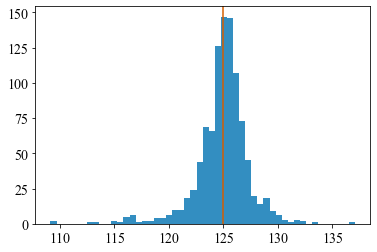

In [36]:
plt.hist(seps_out,bins=50,alpha=0.8);
plt.axvline(125,color=colours[2])

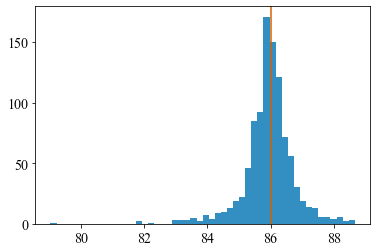

In [37]:
plt.hist(thetas_out,bins=50,alpha=0.8);
plt.axvline(86,color=colours[2])

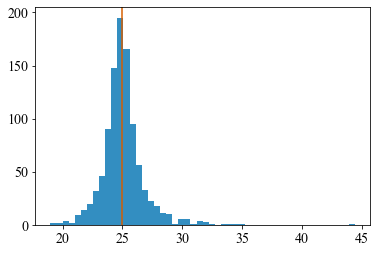

In [38]:
plt.hist(cons_out,bins=50,alpha=0.8);
plt.axvline(25,color=colours[2])

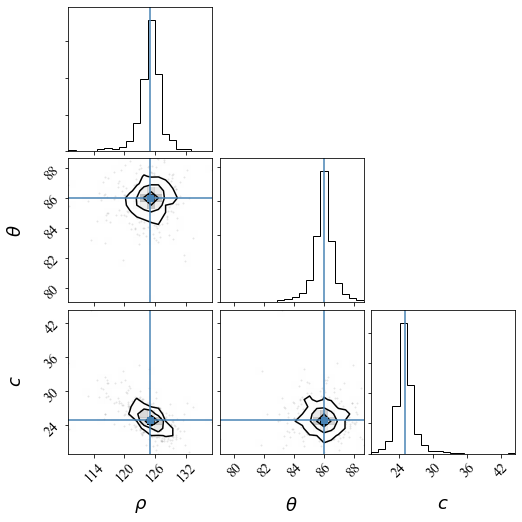

In [39]:
chain = np.array([seps_out,thetas_out,cons_out]).T

# Plot it.
figure = corner.corner(chain, labels=[r"$\rho$", r"$\theta$", r"$c$",],
                       truths=[125,86,25], title_kwargs={"fontsize": 12})



In [49]:
autodiff_all = np.loadtxt('autodiff_all.txt')
import matplotlib.lines as mlines


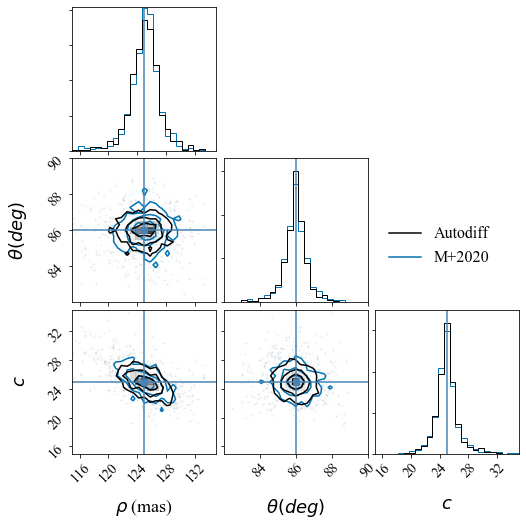

In [55]:
plotrange = ((115,135),(82,90),(15,35))

figure = corner.corner(chain, labels=[r"$\rho$ (mas)", r"$\theta (deg)$", r"$c$",],
                       truths=[125,86,25],range=plotrange,color=colours[0],
                       title_kwargs={"fontsize": 12},bins=25);

corner.corner(autodiff_all, fig=figure,color='k',range=plotrange,bins=25);


lines = [mlines.Line2D([], [], color='k', label='Autodiff'),mlines.Line2D([], [], color=colours[0], label='M+2020')]
plt.legend(handles=lines, bbox_to_anchor=(0., 1.2, 1., .0),fontsize=16,frameon=False);
plt.savefig('comparison_posterior.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/comparison_posterior_sim_cube.pdf',bbox_inches='tight',rasterized=True)

In [42]:
# plt.plot(seps_in,np.zeros_like(seps_in),'-r')
# plt.scatter(seps_in,seps_out-seps_in,c=cons_in)
# plt.colorbar()
# # plt.ylim(-1,6)

In [43]:
# from astropy.table import Table
# test = Table.read('seps_cons_mycode.txt',format='ascii')

In [44]:
# fig = plt.figure(figsize=(8,6))

# # plt.scatter(seps_in,seps_out-seps_in,c=cons_in)
# # plt.scatter(test['seps_in'],test['seps_out']-test['seps_in'],c=test['cons_in'])

# plt.plot(test['seps_in'],test['seps_out']-test['seps_in'],'*',label='Conventional',color=colours[0],markersize=10)
# plt.plot(seps_in,seps_out-seps_in,'.',label='Autodiff',color=colours[2],markersize=11)
# plt.axhline(0,color=colours[1])

# plt.legend(fontsize=16)
# plt.xlabel('Input Separation (mas)')
# plt.ylabel('Error (mas)')
# # plt.colorbar()
# # plt.ylim(-1,6)
# plt.savefig('../paper/separation_comparison.pdf',bbox_inches='tight')

In [45]:
# fig = plt.figure(figsize=(8,6))

# # plt.scatter(seps_in,seps_out-seps_in,c=cons_in)
# # plt.scatter(test['seps_in'],test['seps_out']-test['seps_in'],c=test['cons_in'])

# plt.plot(test['cons_in'],test['cons_out']/test['cons_in'],'*',label='Conventional',color=colours[0],markersize=10)
# plt.plot(cons_in,cons_out/cons_in,'.',label='Autodiff',color=colours[2],markersize=11)
# plt.axhline(1,color=colours[1])

# plt.legend(fontsize=16)
# plt.xlabel('Input Contrast')
# plt.ylabel('Error')
# # plt.colorbar()
# # plt.ylim(-1,6)

In [46]:
# fig = plt.figure(figsize=(8,6))

# # plt.scatter(seps_in,seps_out-seps_in,c=cons_in)
# # plt.scatter(test['seps_in'],test['seps_out']-test['seps_in'],c=test['cons_in'])

# plt.plot(test['thetas_in'],test['thetas_out']/test['thetas_in'],'*',label='Conventional',color=colours[0],markersize=10)
# plt.plot(thetas_in,thetas_out/thetas_in,'.',label='Autodiff',color=colours[2],markersize=11)
# plt.axhline(1,color=colours[1])

# plt.legend(fontsize=16)
# plt.xlabel('Input Contrast')
# plt.ylabel('Error')
# # plt.colorbar()
# # plt.ylim(-1,6)

In [47]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# # plt.scatter(seps_in,seps_out-seps_in,c=cons_in)
# # plt.scatter(test['seps_in'],test['seps_out']-test['seps_in'],c=test['cons_in'])

# ax1.plot(test['cons_in'],test['cons_out']/test['cons_in'],'*',label='Conventional',color=colours[0],markersize=10)
# ax1.plot(cons_in,cons_out/cons_in,'.',label='Autodiff',color=colours[2],markersize=11)
# ax1.axhline(1,color=colours[1])

# ax1.legend(fontsize=16)
# ax1.set_xlabel('Input Contrast')
# ax1.set_ylabel('Error')


# ax2.plot(test['seps_in'],test['seps_out']-test['seps_in'],'*',label='Conventional',color=colours[0],markersize=10)
# ax2.plot(seps_in,seps_out-seps_in,'.',label='Autodiff',color=colours[2],markersize=11)
# ax2.axhline(0,color=colours[1])

# ax2.legend(fontsize=16)
# ax2.set_xlabel('Input Separation (mas)')
# ax2.set_ylabel('Error (mas)')

# # plt.colorbar()
# # plt.ylim(-1,6)
# plt.savefig('../paper/method_comparison_ensemble.pdf',bbox_inches='tight')

In [48]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

# # plt.scatter(seps_in,seps_out-seps_in,c=cons_in)
# # plt.scatter(test['seps_in'],test['seps_out']-test['seps_in'],c=test['cons_in'])

# ax1.plot(test['cons_in'],test['cons_out']/test['cons_in'],'*',label='Conventional',color=colours[0],markersize=10)
# ax1.plot(cons_in,cons_out/cons_in,'.',label='Autodiff',color=colours[2],markersize=11)
# ax1.axhline(1,color=colours[1])

# ax1.legend(fontsize=16)
# ax1.set_xlabel('Input Contrast')
# ax1.set_ylabel('Error')


# ax2.plot(test['seps_in'],test['seps_out']-test['seps_in'],'*',label='Conventional',color=colours[0],markersize=10)
# ax2.plot(seps_in,seps_out-seps_in,'.',label='Autodiff',color=colours[2],markersize=11)
# ax2.axhline(0,color=colours[1])

# ax2.legend(fontsize=16)
# ax2.set_xlabel('Input Separation (mas)')
# ax2.set_ylabel('Error (mas)')

# # plt.colorbar()
# # plt.ylim(-1,6)
# plt.savefig('../paper/method_comparison_ensemble.pdf',bbox_inches='tight')